In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from   scipy import ndimage as ndi
from   skimage import color, io, morphology, segmentation
from   skimage.future import graph

%matplotlib inline

In [2]:
def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    return 0.

In [3]:
# RAG: region adjacency graph
def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, 
                           add_edge_filter, 
                           footprint=footprint, 
                           mode='nearest', 
                           extra_arguments=(g,))
    return g

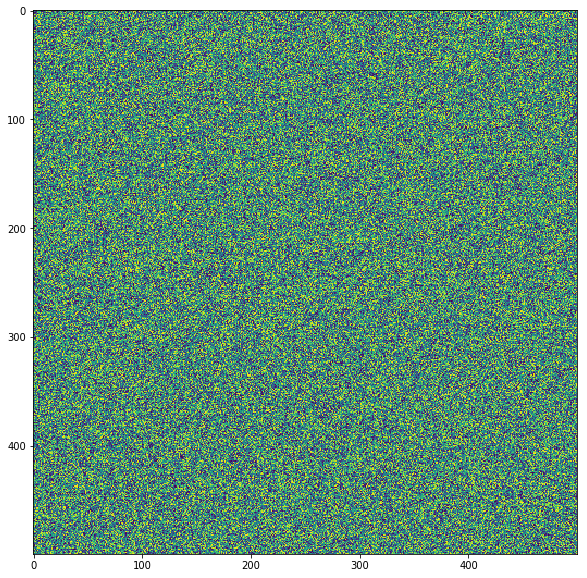

In [4]:
plt.figure(figsize=[10, 10])
random_image = np.random.rand(500, 500)
plt.imshow(random_image);

Type: <class 'imageio.core.util.Array'> Shape: (303, 384) Dtype: uint8


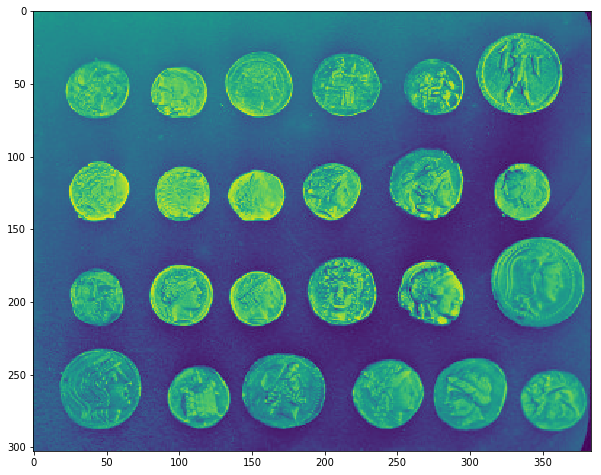

In [5]:
url_coins = ('https://raw.githubusercontent.com/scikit-image/scikit-image/'
             'v0.10.1/skimage/data/coins.png')
coins = io.imread(url_coins)
print('Type:', type(coins), 'Shape:', coins.shape, 'Dtype:', coins.dtype)
plt.figure(figsize=[10, 10])
plt.imshow(coins);

<class 'imageio.core.util.Array'> (512, 512, 3) uint8


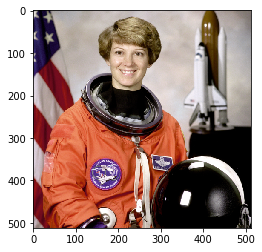

In [6]:
url_astro = ('https://raw.githubusercontent.com/scikit-image/'
             'scikit-image/master/skimage/data/astronaut.png')
astro = io.imread(url_astro)
print(type(astro), astro.shape, astro.dtype)
plt.imshow(astro);

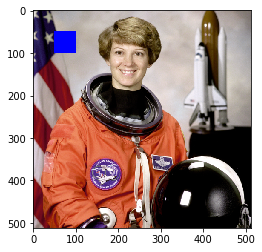

In [7]:
astro_sq = np.copy(astro)
astro_sq[50:100, 50:100] = [0, 0, 255] #RGB
plt.imshow(astro_sq);

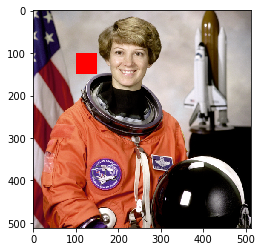

In [8]:
astro_sq = np.copy(astro)
sq_mask = np.zeros(astro.shape[:2], bool)
sq_mask[100:150, 100:150] = True
astro_sq[sq_mask] = [255, 0, 0]
plt.imshow(astro_sq);

In [9]:
def overlay_grid(img, spacing=128):
    '''Return an image with a grid overlay with spacing provided.
    Args:
      img (array (M, N, 3)): Input image
      spacing (int): grid line spacing
    Returns:
      gridded_img (array (M, N, 3)): image with superimposed grid
    '''
    gridded_img = img.copy()
    w, h, _ = gridded_img.shape
    for i in range(spacing, w, spacing):
        gridded_img[i:i+3, 0:h] = [0, 0, 255]
    for j in range(spacing, h, spacing):
        gridded_img[0:w, j:j+3] = [0, 0, 255]
    return gridded_img

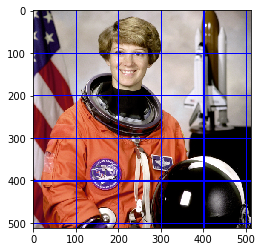

In [10]:
plt.imshow(overlay_grid(astro, 100));

# Filters in Signal Processing

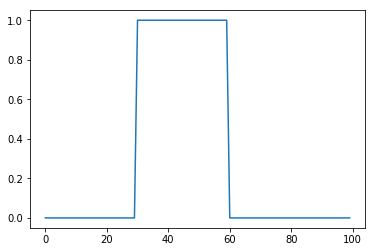

In [11]:
signal = np.zeros(100, np.float)
signal[30:60] = 1 # signal transmitting
fig, ax = plt.subplots()
ax.plot(signal);

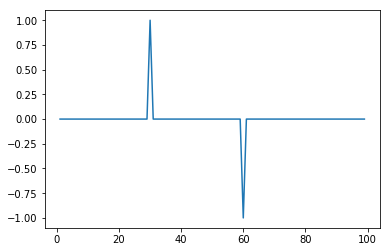

In [12]:
# *WHEN* was the signal switched on/off?
sig_delta = np.diff(signal)
sig_delta = np.concatenate([[np.nan], sig_delta])
fig, ax = plt.subplots()
ax.plot(sig_delta);

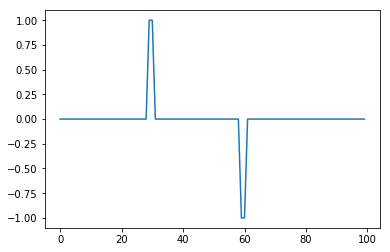

In [13]:
diff = np.array([1, 0, -1]) # the filter/kernel
dsig = ndi.convolve(signal, diff)
plt.plot(dsig);

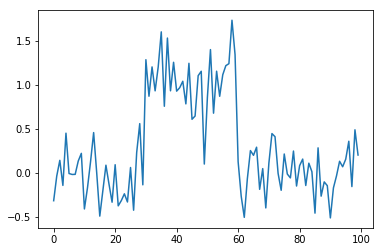

In [14]:
# add noise
signal  += np.random.normal(0, 0.3, size=signal.shape)
plt.plot(signal);

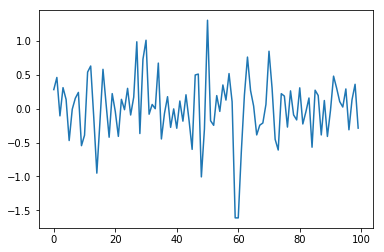

In [15]:
# A plain difference filter ends up amplifying noise
plt.plot(ndi.convolve(signal, diff));

In [16]:
def gaussian_kernel(size, sigma):
    '''<size> should be add and ≥6x <sigma>'''
    positions = np.arange(size) - size // 2
    kernel_raw = np.exp(-positions**2 / (2 * sigma**2))
    kernel_normalized = kernel_raw / kernel_raw.sum()
    return kernel_normalized

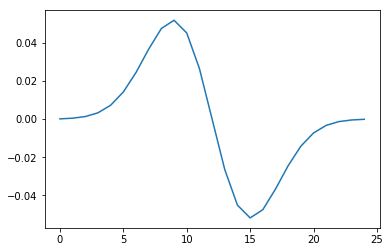

In [17]:
smooth_diff = ndi.convolve(gaussian_kernel(25, 3), diff)
plt.plot(smooth_diff);

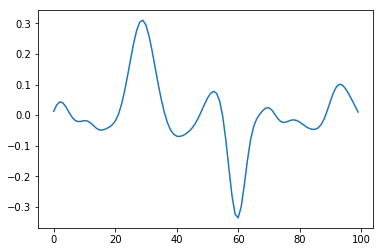

In [18]:
sdsig = ndi.convolve(signal, smooth_diff)
plt.plot(sdsig);

# Filtering Images (2D)

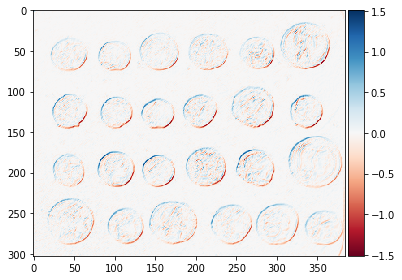

In [19]:
coins = coins.astype(float) / 255
diff2d = np.array([[0,  1,  0],
                   [1,  0, -1], 
                   [0, -1,  0]])
coin_edges = ndi.convolve(coins, diff2d)
io.imshow(coin_edges);

In [20]:
# find horizontal edges
hdiff = np.array([[ 1], 
                  [ 0],
                  [-1]])

In [21]:
# smooth out noise with Sobel filter
h_sobel = np.array([[ 1,  2,  1],
                    [ 0,  0,  0],
                    [-1, -2, -1]])
v_sobel = h_sobel.T

In [22]:
def reduce_xaxis_labels(ax, factor):
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)
    for lab in ax.xaxis.get_ticklabels()[::factor]:
        lab.set_visible(True)

In [23]:
coins_h = ndi.convolve(coins, h_sobel)
coins_v = ndi.convolve(coins, v_sobel)

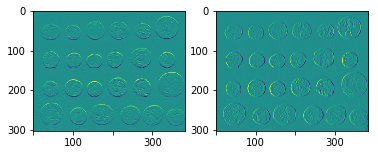

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(coins_h)
axes[1].imshow(coins_v)
for ax in axes:
    reduce_xaxis_labels(ax, 2);

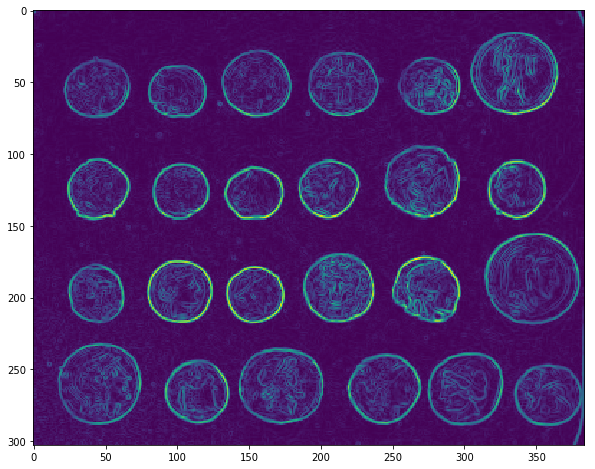

In [25]:
plt.figure(figsize=[10, 8])
coins_sobel = np.sqrt(coins_h**2 + coins_v**2)
plt.imshow(coins_sobel, cmap='viridis');

# Generic Filters
### Arbitrary Functions of Neighborhood Values

In [26]:
def tax(prices):
    return 10000 + 0.05 * np.percentile(prices, 90)

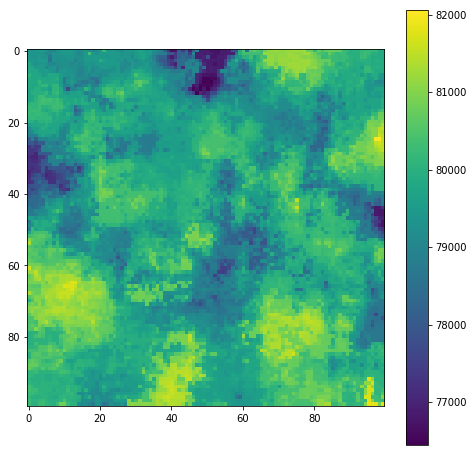

In [27]:
house_price_map = (0.5 + np.random.rand(100, 100)) * 1e6
footprint = morphology.disk(radius=10)
tax_rate_map = ndi.generic_filter(
    house_price_map, tax, footprint=footprint)
plt.figure(figsize=[8, 8])
plt.imshow(tax_rate_map)
plt.colorbar();

# Graphs and the NetworkX Library

In [28]:
conn = pd.read_excel('http://www.wormatlas.org/images/NeuronConnect.xls')
conn.head()

,Neuron 1,Neuron 2,Type,Nbr
0,ADAR,ADAL,EJ,1
1,ADFL,ADAL,EJ,1
2,ASHL,ADAL,EJ,1
3,AVDR,ADAL,EJ,2
4,PVQL,ADAL,EJ,1


In [29]:
conn_edges = [(n1, n2, {'weight': s})
              for n1, n2, t, s in conn.itertuples(index=False, name=None)
              if t.startswith('S')]

In [30]:
wormbrain = nx.DiGraph()
wormbrain.add_edges_from(conn_edges)

In [31]:
centrality = nx.betweenness_centrality(wormbrain)
central = sorted(centrality, key=centrality.get, reverse=True)
print(central[:5])

['AVAR', 'AVAL', 'PVCR', 'PVT', 'PVCL']


In [32]:
sccs = nx.strongly_connected_component_subgraphs(wormbrain)
giant_scc = max(sccs, key=len)
print('The largest strongly connected component has '
      f'{giant_scc.number_of_nodes()} out of {wormbrain.number_of_nodes()}'
      ' total')

The largest strongly connected component has 237 out of 279 total


In [33]:
#in_degrees = list(wormbrain.in_degree().values()) # NOPE
in_degrees = [v for k, v in wormbrain.in_degree]
in_deg_distrib = np.bincount(in_degrees)
avg_in_degree = np.mean(in_degrees)
cumfreq = np.cumsum(in_deg_distrib) / np.sum(in_deg_distrib)
survival = 1 - cumfreq

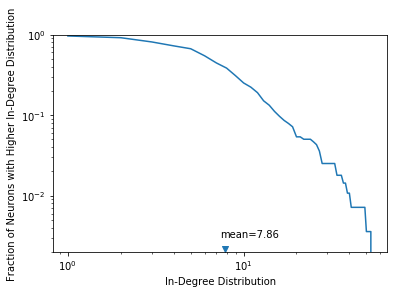

In [34]:
fig, ax = plt.subplots()
ax.loglog(np.arange(1, len(survival) + 1), survival)
ax.set_xlabel('In-Degree Distribution')
ax.set_ylabel('Fraction of Neurons with Higher In-Degree Distribution')
ax.scatter(avg_in_degree, 0.0022, marker='v')
ax.text(avg_in_degree - 0.5, 0.003, f'mean={avg_in_degree:.2f}')
ax.set_ylim(0.002, 1.);

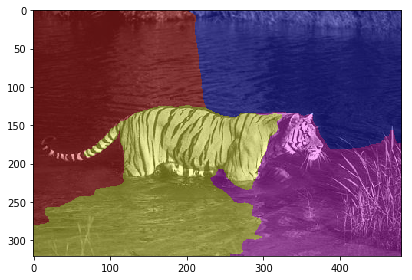

In [35]:
url = ('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/'
       'bsds/BSDS300/html/images/plain/normal/color/108073.jpg')
tiger = io.imread(url)
seg = segmentation.slic(tiger, 
                        n_segments=4, 
                        compactness=40., 
                        enforce_connectivity=True, 
                        sigma=3)
io.imshow(color.label2rgb(seg, tiger));

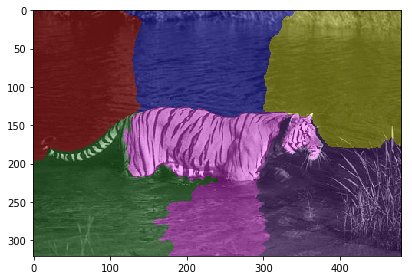

In [36]:
seg = segmentation.slic(tiger, 
                        n_segments=6, 
                        compactness=40., 
                        enforce_connectivity=True, 
                        sigma=3)
io.imshow(color.label2rgb(seg, tiger));

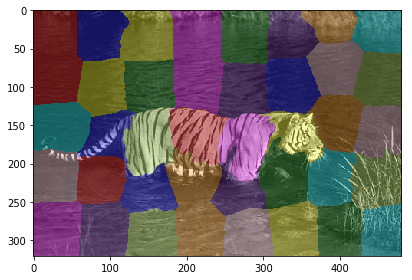

In [37]:
seg = segmentation.slic(tiger, 
                        n_segments=40, 
                        compactness=40., 
                        enforce_connectivity=True, 
                        sigma=3)
io.imshow(color.label2rgb(seg, tiger));

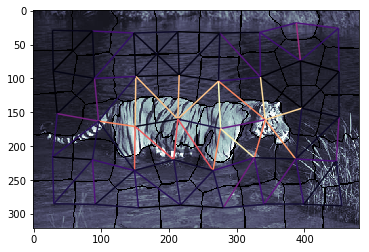

In [38]:
g = graph.rag_mean_color(tiger, seg)
graph.show_rag(seg, g, tiger);

### Building Graphs from Image Regions

In [39]:
def build_rag(labels, image):
    g = nx.Graph()
    row, col = labels.shape
    for r in range(row):
        for c in range(col):
            current_label = labels[r, c]
            if not current_label in g:
                g.add_node(current_label)
                g.node[current_label]['total color'] = np.zeros(
                    3, dtype=np.float)
                g.node[current_label]['pixel count'] = 0
            if r < row - 1 and labels[r + 1, c] != current_label:
                g.add_edge(current_label, labels[r + 1, c])
            if c < col - 1 and labels[r, c + 1] != current_label:
                g.add_edge(current_label, labels[r, c + 1])
            g.node[current_label]['total color'] += image[r, c]
            g.node[current_label]['pixel count'] += 1
    return g

In [40]:
def build_rag_3d(labels, images):
    plane, row, col = lables.shape
    for p in range(plane):
        for r in range(row):
            for c in range(col):
                current_label = labels[p, r, c]
                if not current_label in g:
                    gadd_node(current_label)
                    g.node[current_label]['total_color'] = np.zeros(
                        3, dtype=np.float)
                    g.node[current_label]['pixel_count'] = 0
                if p < plane - 1 and labels[p + 1, r, c] != current_label:
                    g.add_edge(current_label, labels[p + 1, r, c])
                if r < row - 1 and labels[p, r + 1, c] != current_label:
                    g.add_edge(current_label, labels[p, r + 1, c])
                if c < col - 1 and labels[p, r, c + 1] != current_label:
                    g.add_edge(current_label, labels[p, r, c + 1])
                g.node[current_label]['total color'] += image[p, r, c]
                g.node[current_label]['pixiel count'] += 1
    return g

In [41]:
# Better versions using scipy strengths
def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    # float return val is unused, but needed by generic_filter
    return 0.

In [42]:
def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, 
                           add_edge_filter, 
                           footprint=footprint, 
                           mode='nearest', 
                           extra_arguments=(g,))
    for n in g:
        g.node[n]['total color'] = np.zeros(3, np.double)
        g.node[n]['pixel count'] = 0
    for idx in np.ndindex(labels.shape):
        n = labels[idx]
        g.node[n]['total color'] += image[idx]
        g.node[n]['pixel count'] += 1
    return g

In [44]:
g = build_rag(seg, tiger)
for n in g:
    node = g.node[n]
    node['mean'] = node['total color'] / node['pixel count']
for u, v in g.edges():
    d = g.node[u]['mean'] - g.node[v]['mean']
    g[u][v]['weight'] = np.linalg.norm(d)

In [47]:
def threshold_graph(g, t):
    to_remove = [(u, v) for (u, v, d) in g.edges(data=True) 
                 if d['weight'] > t]
    g.remove_edges_from(to_remove)

In [48]:
threshold_graph(g, 80)

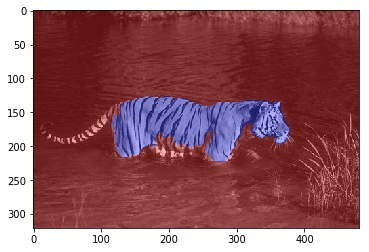

In [51]:
map_array = np.zeros(np.max(seg) + 1, int)
for i, segment in enumerate(nx.connected_components(g)):
    for initial in segment:
        map_array[int(initial)] = i
segmented = map_array[seg]
plt.imshow(color.label2rgb(segmented, tiger));